In [2]:
import pandas as pd

# Load the datasets
yield_data = pd.read_csv('h5_i2_2019-2022_hand_harvest.csv')
agb_data = pd.read_csv('I2_CC_AGB_2020-2022.csv')

# Inspect columns
print("Yield data columns:", yield_data.columns.tolist())
print("AGB data columns:", agb_data.columns.tolist())

# Clean column names (strip whitespace)
yield_data.columns = yield_data.columns.str.strip()
agb_data.columns = agb_data.columns.str.strip()

print("\nAfter cleaning:")
print("Yield data columns:", yield_data.columns.tolist())
print("AGB data columns:", agb_data.columns.tolist())

# Determine merge keys based on available columns
merge_keys = []
for key in ['Year', 'Site', 'Treatment']:
    if key in yield_data.columns and key in agb_data.columns:
        merge_keys.append(key)

print("\nMerge keys found:", merge_keys)

# Perform merge
if merge_keys:
    merged_crop_data = pd.merge(yield_data, agb_data, on=merge_keys, how='outer')
else:
    # If no common keys, try merging on Year and other available keys
    common_keys = [col for col in yield_data.columns if col in agb_data.columns]
    print(f"Using common keys: {common_keys}")
    merged_crop_data = pd.merge(yield_data, agb_data, on=common_keys, how='outer') if common_keys else yield_data

# Display the first few rows
print(f"\nMerged data shape: {merged_crop_data.shape}")
print(merged_crop_data.head())

Yield data columns: ['Date', 'DoY', 'Year', 'Crop', 'Site', 'Treatment', 'Rep', 'Sample', 'Site.Rep', 'Percent_H2O', 'AGB_g_m2', 'Grain_yield_g_m2', 'Grain_yield_kg_ha', 'Stover_g_m2', 'Harvest_index']
AGB data columns: ['STUDY', 'SITE', 'SITEID', 'DATE', 'TRT', 'CC_AGB']

After cleaning:
Yield data columns: ['Date', 'DoY', 'Year', 'Crop', 'Site', 'Treatment', 'Rep', 'Sample', 'Site.Rep', 'Percent_H2O', 'AGB_g_m2', 'Grain_yield_g_m2', 'Grain_yield_kg_ha', 'Stover_g_m2', 'Harvest_index']
AGB data columns: ['STUDY', 'SITE', 'SITEID', 'DATE', 'TRT', 'CC_AGB']

Merge keys found: []
Using common keys: []

Merged data shape: (260, 15)
        Date  DoY  Year         Crop  Site Treatment  Rep  Sample Site.Rep  \
0  8/20/2019  232  2019  SpringWheat  H501       BAU    1       1    BAU.1   
1  8/20/2019  232  2019  SpringWheat  H502       BAU    2       1    BAU.2   
2  8/20/2019  232  2019  SpringWheat  H503       BAU    3       1    BAU.3   
3  8/20/2019  232  2019  SpringWheat  H504       BA

In [3]:
!pip install seaborn

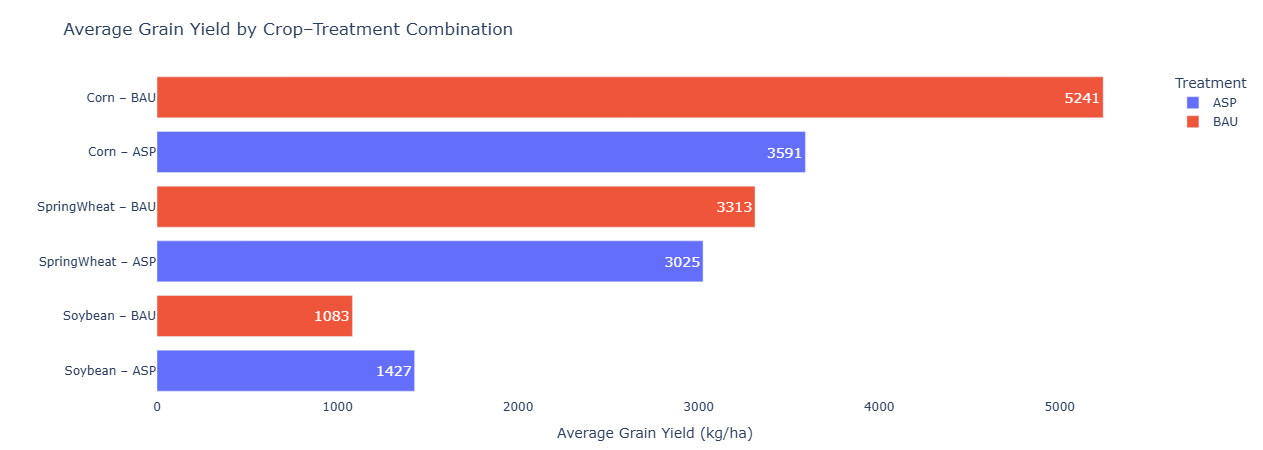

In [38]:
# THEME 1 – QUESTION 1:
# Which crop or treatment combinations have the highest average grain yield?

import plotly.express as px

# 1. Summarize yield by Crop and Treatment
yield_summary = (
    merged_crop_data
    .groupby(['Crop', 'Treatment'], as_index=False)['Grain_yield_kg_ha']
    .mean()
)

# 2. Create combined label
yield_summary['Crop_Treatment'] = (
    yield_summary['Crop'].astype(str) + " – " + yield_summary['Treatment'].astype(str)
)

# 3. Desired DESCENDING display order (TOP → BOTTOM)
display_order = [
    "Corn – BAU",
    "Corn – ASP",
    "SpringWheat – BAU",
    "SpringWheat – ASP",
    "Soybean – BAU",
    "Soybean – ASP",
]

# 4. Build the bar chart
fig = px.bar(
    yield_summary,
    x='Grain_yield_kg_ha',
    y='Crop_Treatment',
    color='Treatment',
    orientation='h',
    category_orders={"Crop_Treatment": display_order},
    text='Grain_yield_kg_ha',   # <-- text comes from the same column used for x
    labels={
        'Grain_yield_kg_ha': 'Average Grain Yield (kg/ha)',
        'Crop_Treatment': ''
    },
    title='Average Grain Yield by Crop–Treatment Combination',
)


# 6. Format labels inside bars
fig.update_traces(
    texttemplate="%{text:.0f}",
    textposition="inside",
    insidetextanchor="end",
    textfont=dict(color="white", size=14)
)

# 7. Clean layout
fig.update_layout(
    height=450,
    width=750,
    bargap=0.25,
    plot_bgcolor="white",
    xaxis=dict(showgrid=False, title="Average Grain Yield (kg/ha)"),
    yaxis_title="",
    margin=dict(l=140, r=40, t=70, b=40),
    legend_title="Treatment"
)

fig.show()


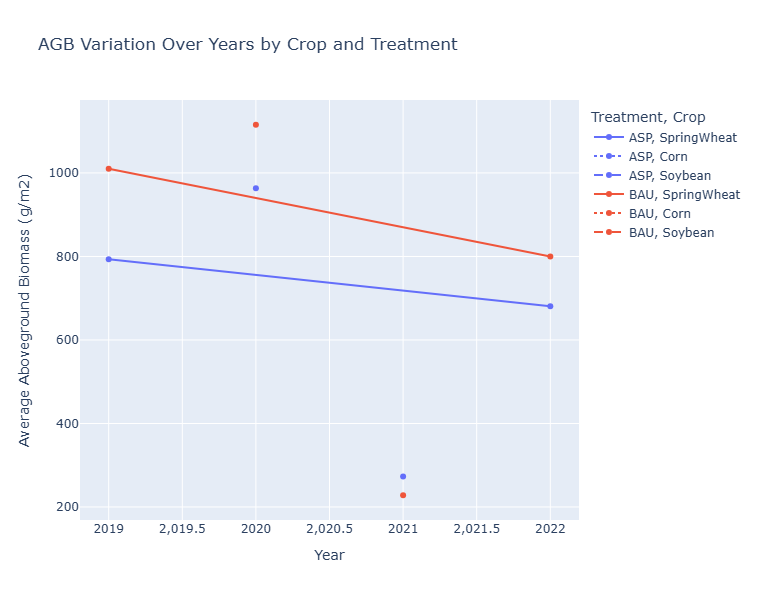

In [5]:
# THEME 1 – QUESTION 2: How does aboveground biomass (AGB) vary by year, crop type, and management practice?
# Group by Year, Crop, and Treatment for AGB mean
agb_variation = merged_crop_data.groupby(['Year', 'Crop', 'Treatment'])['AGB_g_m2'].mean().reset_index()

# Plotly Line Chart - Interactive
fig = px.line(agb_variation, x='Year', y='AGB_g_m2', color='Treatment', line_dash='Crop',
              title='AGB Variation Over Years by Crop and Treatment',
              labels={'AGB_g_m2': 'Average Aboveground Biomass (g/m2)', 'Year': 'Year'},
              markers=True,
              hover_data={'AGB_g_m2': ':.2f', 'Year': 'd'})
fig.update_layout(hovermode='x unified', height=600, width=1000, legend=dict(x=1.02, y=0.99))
fig.show()

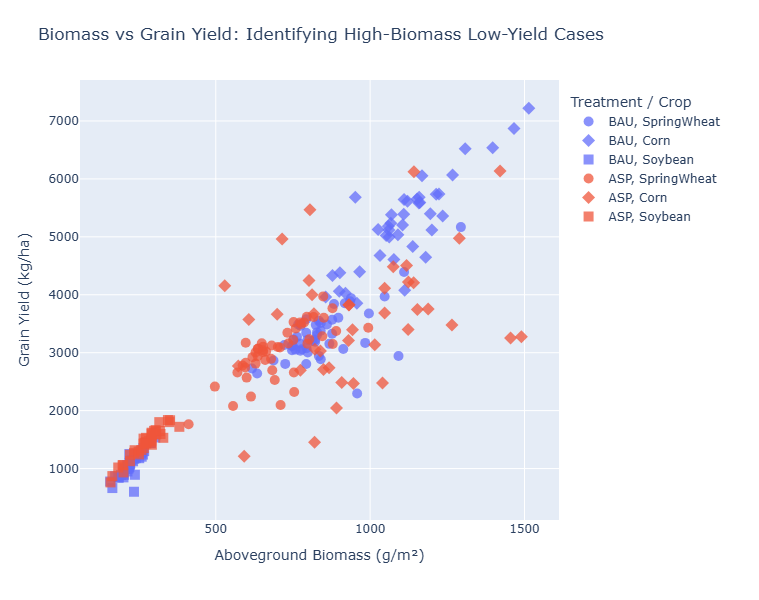

In [19]:
# THEME 1 – QUESTION 3: Are there crops or treatments with high biomass 
# but low grain yield (low harvest index)?

import plotly.express as px

# Ensure numeric types
yield_data["AGB_g_m2"] = pd.to_numeric(yield_data["AGB_g_m2"], errors="coerce")
yield_data["Grain_yield_kg_ha"] = pd.to_numeric(yield_data["Grain_yield_kg_ha"], errors="coerce")

# Filter rows with valid values
scatter_df = yield_data.dropna(subset=["AGB_g_m2", "Grain_yield_kg_ha"])

# Create scatter plot
fig_scatter = px.scatter(
    scatter_df,
    x="AGB_g_m2",
    y="Grain_yield_kg_ha",
    color="Treatment",
    symbol="Crop",
    hover_data=["Year", "Site", "Rep"],
    labels={
        "AGB_g_m2": "Aboveground Biomass (g/m²)",
        "Grain_yield_kg_ha": "Grain Yield (kg/ha)"
    },
    title="Biomass vs Grain Yield: Identifying High-Biomass Low-Yield Cases"
)

# Improve readability
fig_scatter.update_traces(marker=dict(size=10, opacity=0.75))
fig_scatter.update_layout(
    height=600,
    width=900,
    hovermode="closest",
    legend=dict(
        title="Treatment / Crop",
        orientation="v",
        yanchor="top",
        y=0.98,
        xanchor="left",
        x=1.02,     # push legend slightly to the right of plotting area
    ),
    margin=dict(l=80, r=200, t=80, b=80)  # extra space on the right for legend text
)
fig_scatter.show()


Available treatments: ['BAU' 'ASP']

--- Descriptive Statistics: BAU vs. ASP ---
  Treatment   Mean_Yield  Mean_Biomass
0       ASP  2707.361933    650.915385
1       BAU  3219.754517    737.284615

--- T-Test Results (Statistical Significance) ---
Yield T-Test (BAU vs. ASP): T=2.85, P-value=0.0048
  Conclusion: Statistically significant difference in Yield.
Biomass T-Test (BAU vs. ASP): T=2.01, P-value=0.0451
  Conclusion: Statistically significant difference in Biomass.


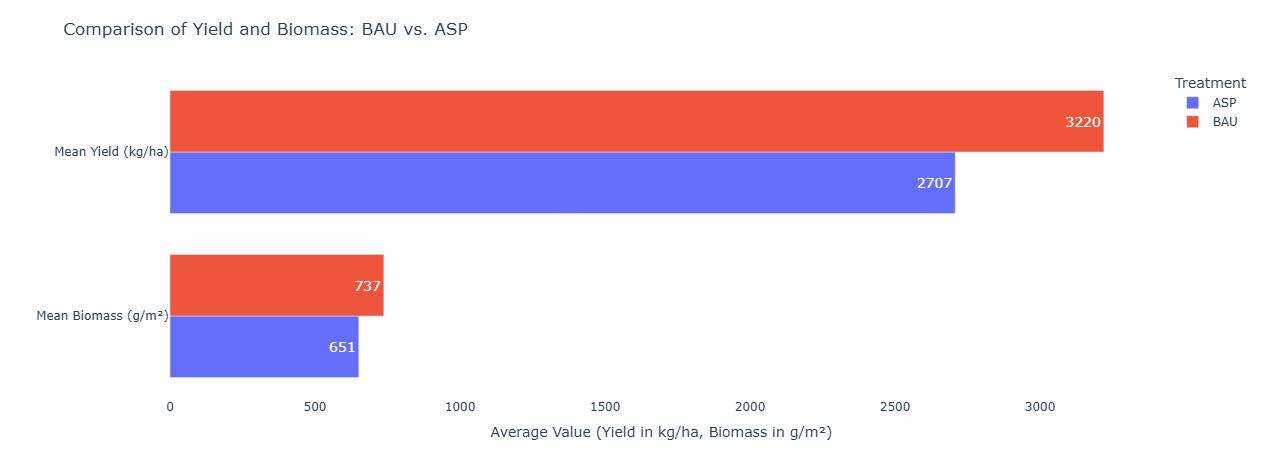

In [41]:
# THEME 1 – QUESTION 4: Does the aspirational treatment (cover crops + residue retention) improve yield and biomass compared to business-as-usual?
import plotly.express as px
from scipy import stats
import subprocess
import sys

# Install scipy if needed
try:
    from scipy.stats import ttest_ind
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scipy", "-q"])
    from scipy.stats import ttest_ind

if not merged_crop_data.empty:
    # Define the two treatments of interest (use actual values from data)
    treatments = merged_crop_data['Treatment'].unique()
    print(f"Available treatments: {treatments}")
    
    if len(treatments) >= 2:
        TREATMENT_1 = treatments[0]
        TREATMENT_2 = treatments[1]
    else:
        TREATMENT_1, TREATMENT_2 = 'ASP', 'BAU'

    # --- 1. Filter Data for Comparison ---
    comparison_df = merged_crop_data[merged_crop_data['Treatment'].isin([TREATMENT_1, TREATMENT_2])].copy()
    
    # --- 2. Descriptive Statistics (Mean Yield and Biomass) ---
    comparison_summary = comparison_df.groupby('Treatment').agg(
        Mean_Yield=('Grain_yield_kg_ha', 'mean'),
        Mean_Biomass=('AGB_g_m2', 'mean')
    ).reset_index()

    print(f"\n--- Descriptive Statistics: {TREATMENT_1} vs. {TREATMENT_2} ---")
    print(comparison_summary)

    # --- 3. Statistical Comparison (T-test) ---
    asp_yield = comparison_df[comparison_df['Treatment'] == TREATMENT_1]['Grain_yield_kg_ha'].dropna()
    bau_yield = comparison_df[comparison_df['Treatment'] == TREATMENT_2]['Grain_yield_kg_ha'].dropna()
    
    asp_agb = comparison_df[comparison_df['Treatment'] == TREATMENT_1]['AGB_g_m2'].dropna()
    bau_agb = comparison_df[comparison_df['Treatment'] == TREATMENT_2]['AGB_g_m2'].dropna()
    
    print("\n--- T-Test Results (Statistical Significance) ---")
    
    # T-test for Yield
    if len(asp_yield) > 1 and len(bau_yield) > 1:
        t_yield, p_yield = ttest_ind(asp_yield, bau_yield, equal_var=False)
        print(f"Yield T-Test ({TREATMENT_1} vs. {TREATMENT_2}): T={t_yield:.2f}, P-value={p_yield:.4f}")
        if p_yield < 0.05:
            print("  Conclusion: Statistically significant difference in Yield.")
        else:
            print("  Conclusion: No statistically significant difference in Yield.")
    else:
        print(f"Not enough data to run T-test for Yield. {TREATMENT_1}: {len(asp_yield)}, {TREATMENT_2}: {len(bau_yield)}")

    # T-test for Biomass
    if len(asp_agb) > 1 and len(bau_agb) > 1:
        t_agb, p_agb = ttest_ind(asp_agb, bau_agb, equal_var=False)
        print(f"Biomass T-Test ({TREATMENT_1} vs. {TREATMENT_2}): T={t_agb:.2f}, P-value={p_agb:.4f}")
        if p_agb < 0.05:
            print("  Conclusion: Statistically significant difference in Biomass.")
        else:
            print("  Conclusion: No statistically significant difference in Biomass.")
    else:
        print(f"Not enough data to run T-test for Biomass. {TREATMENT_1}: {len(asp_agb)}, {TREATMENT_2}: {len(bau_agb)}")

    # --- 4. Visualization of Comparison (After-style horizontal bars) ---
    plot_data = comparison_summary.melt(
        id_vars='Treatment',
        value_vars=['Mean_Yield', 'Mean_Biomass'],
        var_name='Metric',
        value_name='Value'
    )

    # Pretty labels for the y-axis
    metric_labels = {
        'Mean_Yield': 'Mean Yield (kg/ha)',
        'Mean_Biomass': 'Mean Biomass (g/m²)'
    }
    plot_data['Metric_pretty'] = plot_data['Metric'].map(metric_labels)

    # Ensure ASP is always on top, BAU underneath
    treatment_order = ['ASP', 'BAU']
    metric_order = ['Mean Yield (kg/ha)', 'Mean Biomass (g/m²)']

    fig_comparison = px.bar(
        plot_data,
        x='Value',
        y='Metric_pretty',
        color='Treatment',
        orientation='h',
        barmode='group',
        category_orders={
            'Treatment': treatment_order,
            'Metric_pretty': metric_order
        },
        text='Value',   # <- IMPORTANT: let Plotly map text from the same column it uses
        title=f'Comparison of Yield and Biomass: {TREATMENT_1} vs. {TREATMENT_2}',
        labels={
            'Value': 'Average Value (Yield in kg/ha, Biomass in g/m²)',
            'Metric_pretty': '',
            'Treatment': 'Treatment'
        },
        hover_data={'Value': ':.1f'}
    )

    # Inside labels that match hover values
    fig_comparison.update_traces(
        texttemplate='%{text:.0f}',
        textposition='inside',
        insidetextanchor='end',
        textfont=dict(color='white', size=14)
    )

    # Clean layout, similar to Theme 1 – Q1
    fig_comparison.update_layout(
        height=450,
        width=750,
        bargap=0.25,
        plot_bgcolor='white',
        xaxis=dict(
            title='Average Value (Yield in kg/ha, Biomass in g/m²)',
            showgrid=False
        ),
        yaxis_title='',
        margin=dict(l=140, r=40, t=70, b=40),
        legend_title='Treatment',
        hovermode='closest'
    )

    fig_comparison.show()

else:
    print("merged_crop_data is empty. Please ensure cell 1 has been executed successfully.")